# Using Low-Rank Kernel Matrix Approximation on OKGT -- Nystroem -- Laplace Kernel

**Note** Laplace kernel is used throughout this document.

This notebook tests the effect of using Nystroem kernel matrix approximation on OKGT. The Nystroem method is provided in `sklearn.kernel_approximation`.

We use the same model which is from [this post](http://partofthething.com/ace/samples.html). The following is the model representation:

$$
Y = \ln (4 + \sin(4X_0)) + |X_1| + X_2^2 + X_3^3 + X_4 + 0.1\epsilon
$$

where $\epsilon \sim N(0,1)$ and each covariate is simulated from $Unif(-1,1)$.

In [262]:
# Simulate data
import okgtreg.simulate as simulate
import okgtreg.kernel_selector as ks
import numpy as np
import scipy as sp
from sklearn.kernel_approximation import Nystroem

np.random.seed(10)
n = 20000 # sample size
y, x = simulate.SimData_Wang04(n)
y = np.matrix(y)
x = np.matrix(x)

In [263]:
# Specify the constants, regularization coefficient and kernel functions
eps = 1e-6 # regularization term

p = x.shape[1]
xGroup = [[i+1] for i in range(p)]
# kfn = ks.KernelSelector('Gaussian', sigma=0.5) # Gaussian kernel
kfn = ks.KernelSelector('Laplace', alpha=0.3) # Laplace kernel
xkfnlist = [kfn]*p
ykfnlist = [kfn]

Next, we construct the Nystroem instance, and then estimate an approximation for our kernel matrices.

**Note** The [sklearn page](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem.fit_transform) doesn't show much information on how to use the Nystroem class. More information can be found in the [test codes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tests/test_kernel_approximation.py).

In [264]:
# Create Nystroem instance
nystroem = Nystroem(kfn, n_components=35)

print type(nystroem)

<class 'sklearn.kernel_approximation.Nystroem'>


In [265]:
# Use Nystroem on our data

# We define a function so that it can be applied on all variables.
def ApplyNystroemOnKernelMatrix(x, nystroem):
    return np.matrix(nystroem.fit_transform(x))

Get $G$ so that $K \approx G G^T$. **Note** Kernel matrix $K$ is not centered yet.

In [266]:
Gy = ApplyNystroemOnKernelMatrix(y, nystroem)

print 'Gy type and dimension:\n', type(Gy), Gy.shape

Gy type and dimension:
<class 'numpy.matrixlib.defmatrix.matrix'> (20000, 35)


Apply SVD on $N_0G = USV$, where $N_0$ is a centering matrix. Then we can have $N_0 K N_0 \approx U S^2 U^T$. Denote $\Lambda := S^2$.

In [267]:
# SVD
N0 = np.identity(n) - np.ones((n,n))/n
Uy, Gy_s, Gy_V = np.linalg.svd(N0 * Gy, full_matrices=0)
lambday = Gy_s**2

print 'Uy type and dimension:\n', type(Uy), Uy.shape
print 'Retained eigen values of Ky:\n', lambday

Uy type and dimension:
<class 'numpy.matrixlib.defmatrix.matrix'> (20000, 35)
Retained eigen values of Ky:
[  7.25033129e+02   2.37095387e+02   1.07024154e+02   6.14213316e+01
   3.90036452e+01   2.54823166e+01   1.88302724e+01   1.33827208e+01
   1.05300806e+01   7.83583832e+00   6.73842746e+00   4.85442118e+00
   4.37938743e+00   3.20173964e+00   2.83097330e+00   2.53937503e+00
   1.92300692e+00   1.72247195e+00   1.38054441e+00   1.30663904e+00
   1.18298403e+00   1.02176688e+00   8.46339471e-01   7.99746649e-01
   7.78694763e-01   6.09633289e-01   5.99280427e-01   5.76399617e-01
   3.05055795e-01   1.37976926e-01   1.16532947e-01   1.04674046e-01
   9.33846611e-02   4.04844102e-02   1.81339266e-02]


In [268]:
# Do the same thing for all X
Ux = []
lambdax = []
for i in range(p):
    Gi = ApplyNystroemOnKernelMatrix(x[:,i], nystroem)
    print 'Gi shape:', Gi.shape
    Ui, Gi_s, Gi_V = np.linalg.svd(N0 * Gi, full_matrices=0)
    print 'Ui shape:', Ui.shape
    Ux.append(Ui)
    lambdai = Gi_s**2
    print 'lambdai:', lambdai
    lambdax.append(lambdai)

Gi shape: (20000, 35)
Ui shape: (20000, 35)
lambdai: [  1.93180295e+03   5.86726155e+02   2.50762284e+02   1.47322124e+02
   8.81583721e+01   6.08669681e+01   4.42605720e+01   2.97593918e+01
   2.45623439e+01   1.98094823e+01   1.30986099e+01   1.20520866e+01
   1.01011342e+01   7.64972877e+00   7.32810330e+00   4.54518842e+00
   4.11822446e+00   3.18586994e+00   3.03878233e+00   2.30211006e+00
   2.24429812e+00   1.98203484e+00   1.75230842e+00   1.44310667e+00
   9.01391576e-01   8.41407660e-01   6.77024721e-01   4.92337064e-01
   4.32287406e-01   3.71802861e-01   3.26026993e-01   2.62320228e-01
   1.67729767e-01   4.90412824e-02   5.94211244e-03]
Gi shape: (20000, 35)
Ui shape: (20000, 35)
lambdai: [  1.90619061e+03   5.86616911e+02   2.54287031e+02   1.42324820e+02
   8.98556109e+01   5.96722751e+01   4.25656029e+01   3.17271811e+01
   2.35722395e+01   1.88172130e+01   1.49614192e+01   1.19199292e+01
   9.50140862e+00   7.83454112e+00   6.57708405e+00   5.51653172e+00
   5.14846597

Then, we construct the necessary matrices for estimating covariance and cross-covariance operators.

In [269]:
# Construct covariance operators
lambdax_row = np.hstack(lambdax)
Ux_row = np.hstack(Ux)
Ux_diag = sp.sparse.block_diag(Ux)

T = np.diag(lambday / (lambday + eps)) * Uy.T * Ux_row * np.diag(lambdax_row)
R = np.diag((lambdax_row + eps)**2) + \
        np.diag(lambdax_row) * (Ux_row.T * Ux_row - np.identity(len(lambdax_row))) * np.diag(lambdax_row)
    
R_inv = np.linalg.inv(R)

In [270]:
vv = T*R_inv*T.T

In [271]:
my = vv.shape[0]
eigval, eigvec = sp.linalg.eigh(vv, eigvals=(my-1, my-1))

print 'Largest eigen value = ', float(eigval)

Largest eigen value =  0.985310549848


In [272]:
g_opt = Uy * np.diag(lambday) * np.matrix(eigvec)

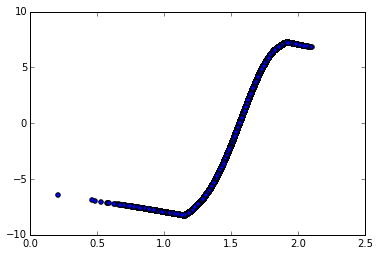

In [273]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(y, g_opt)

In [274]:
f_opt = np.diag(np.sqrt(lambday**2 + eps) * lambday) * np.matrix(eigvec)
f_opt = T.T * f_opt
f_opt = R_inv * f_opt
f_opt = np.diag(lambdax_row) * f_opt
f_opt = Ux_diag * f_opt

f_opt = f_opt.reshape((n, p), order='F')

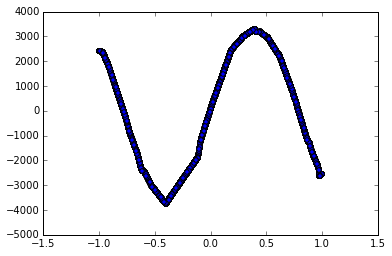

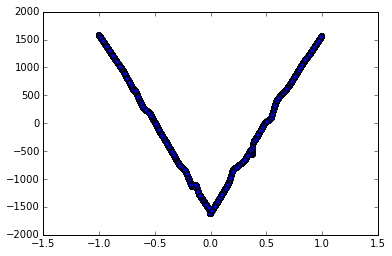

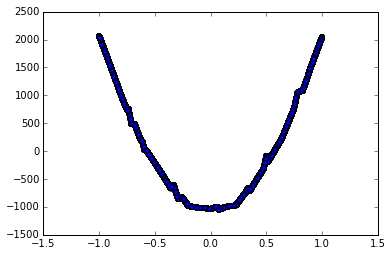

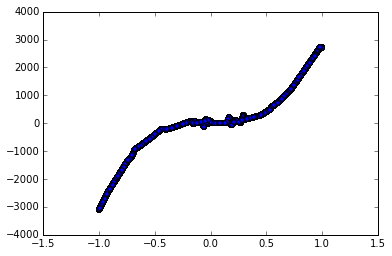

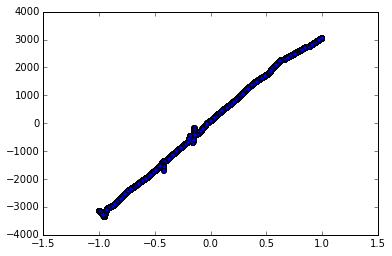

In [275]:
plt.figure()
plt.scatter(x[:,0], f_opt[:,0])
plt.show()

plt.figure()
plt.scatter(x[:,1], f_opt[:,1])
plt.show()

plt.figure()
plt.scatter(x[:,2], f_opt[:,2])
plt.show()

plt.figure()
plt.scatter(x[:,3], f_opt[:,3])
plt.show()

plt.figure()
plt.scatter(x[:,4], f_opt[:,4])
plt.show()